In [1]:
%reload_ext autoreload

import pandas as pd

import numpy as np

from sklearn.linear_model import LogisticRegression

from make_ready_data.make_ready_big_data import read_data, get_label, get_feat

from make_ready_data.make_ready_big_data import look_through_info, get_train_and_test_sets

from make_ready_data.make_ready_short_data import get_short_test_data_from_Roman

from make_ready_data.make_ready_short_data import get_short_test_data_from_Svetlana_G

from make_ready_data.create_features_indeces import get_labels_and_features_indeces

from make_ready_data.create_features_indeces import build_plot_for_best_features

from testing.testing_functions import testing_sick_patients, \
                    testing_sick_samples, extraxt_samples_from_new_test_data

In [3]:
info, final_filelist = read_data()

data_sick, data_heal, inds_sick, inds_heal = look_through_info(info, final_filelist)

plot_labels, indlist = get_labels_and_features_indeces()

In [4]:
test_patients_data = get_short_test_data_from_Svetlana_G(dirpath='../data/test_data/')

test_patients_data.append(('Roman_patient', get_short_test_data_from_Roman()))


TQ_manualis dropped


In [10]:
_, _, _, _, patients_data = get_train_and_test_sets(data_sick, data_heal, 
                                                               inds_sick, inds_heal, 0, 
                                                               balanced_data=True,
                                                               make_shuffle=True)
len(patients_data)

84

In [11]:
def extract_heal_patients(patients_data, max_samles_number=92):
    heal_patients_data = []
    rest_patients_data = patients_data.copy()
    samples_number = 0
    for i, data in enumerate(patients_data):
        if data[0,-1] == 0:
            if samples_number+data.shape[0] > max_samles_number:
                break
            heal_patients_data.append(data)
            rest_patients_data.remove(data)
            samples_number += data.shape[0]            
    return heal_patients_data, rest_patients_data

In [12]:
def form_train_data(rest_patients_data):
#     train_data = np.concatenate((tr_d, tr_l.reshape((-1, 1))), axis=1)
    train_data = np.empty((0, 6))
    for data in rest_patients_data:
        train_data = np.concatenate((train_data, data))
    return train_data

In [13]:
def form_test_data(heal_patients_data, test_patients_data):
    test_data = np.empty((0, 6))
    for i, data in enumerate(test_patients_data):
        labels = np.ones((data[1].shape[0], 1))
        data_with_labels = np.concatenate((data[1], labels), axis=1)
        test_data = np.concatenate((test_data, data_with_labels))
    for i, data in enumerate(heal_patients_data):
        test_data = np.concatenate((test_data, data))
    return test_data

In [14]:
def calculate_sensitivity_and_specificity_on_samples(train_data, test_data, indlist):
    sens = np.zeros(len(indlist))
    spec = np.zeros(len(indlist))
    for i, inds in enumerate(indlist):
        clf = LogisticRegression(C=1000.)
        clf.fit(train_data[:, inds], train_data[:, -1])
        log_res = clf.predict(test_data[:, inds])
        sens[i] = (log_res*test_data[:, -1]).sum() / test_data[:, -1].sum()
        spec[i] = ((log_res==0)*(test_data[:, -1]==0)).sum() / (test_data[:, -1]==0).sum()
    return sens, spec

In [15]:
heal_patients_data, rest_patients_data = extract_heal_patients(patients_data, max_samles_number=100)
test_data = form_train_data(rest_patients_data)
train_data = form_test_data(heal_patients_data, test_patients_data)
sens, spec = calculate_sensitivity_and_specificity_on_samples(train_data, test_data, indlist)

In [18]:
def calc_aver_sens_spec_on_samples(patients_data):
    n_test = 500
    aver_sens = np.zeros(len(indlist))
    aver_spec = np.zeros(len(indlist))
    for i in range(n_test):
        if i%100==0:
            print(i)
        tr_d, ts_d, tr_l, ts_l, patients_data = get_train_and_test_sets(data_sick, data_heal, 
                                                                   inds_sick, inds_heal, 0.8, 
                                                                   balanced_data=True,
                                                                   make_shuffle=True)
        heal_patients_data, rest_patients_data = extract_heal_patients(patients_data, max_samles_number=100)
        test_data = form_train_data(rest_patients_data)
        train_data = form_test_data(heal_patients_data, test_patients_data)
        sens, spec = calculate_sensitivity_and_specificity_on_samples(train_data, test_data, indlist)
        aver_sens += sens
        aver_spec += spec
    return aver_sens / n_test, aver_spec / n_test

In [19]:
aver_sens, aver_spec = calc_aver_sens_spec_on_samples(patients_data)

0
100
200
300
400


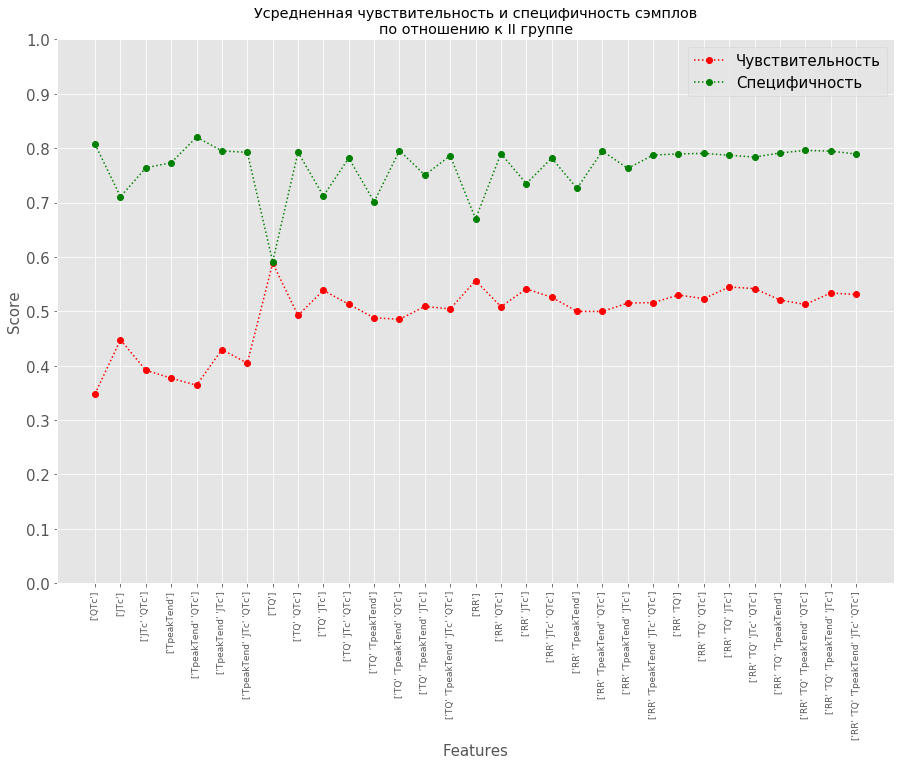

In [20]:
build_plot_for_best_features(plot_labels, indlist,
                             y=[aver_sens, aver_spec],
                             y_arange=np.arange(0., 1.1 ,0.1),
                             marker=[':ro', ':go'],
                             legend_label=['Чувствительность', 
                                           'Специфичность'], 
                             title='Усредненная чувствительность и специфичность сэмплов\nпо отношению к II группе', 
                             savefile_name='aver_sens_spec_II_group_samples')

In [21]:
def form_sick_and_heal_test_patients_data(heal_patients_data, test_patients_data):
    test_data_without_filenames = []
    for data in test_patients_data:
        labels = np.ones((data[1].shape[0], 1))
        new_data = np.concatenate((data[1], labels), axis=1)
        test_data_without_filenames.append(new_data)
    return test_data_without_filenames + heal_patients_data

In [22]:
def calculate_sensitivity_and_specificity_on_patients(train_data, test_patients_data, indlist):
    sens = np.zeros(len(indlist))
    spec = np.zeros(len(indlist))
    patients_labels = np.array([data[0,-1] for data in test_patients_data])
    for i, inds in enumerate(indlist):
        clf = LogisticRegression(C=1000.)
        clf.fit(train_data[:, inds], train_data[:, -1])
        log_res = np.empty(len(test_patients_data))
        for j, data in enumerate(test_patients_data):
            one_patient_log_res = clf.predict(data[:, inds])
            log_res[j] = round(one_patient_log_res.sum()/one_patient_log_res.shape[0]+0.0001)

        sens[i] = (log_res*patients_labels).sum() / patients_labels.sum()
        spec[i] = ((log_res==0)*(patients_labels==0)).sum() / (patients_labels==0).sum()
    return sens, spec

In [23]:
# full_test_patients_data = form_sick_and_heal_test_patients_data(heal_patients_data, test_patients_data)
sens, spec = calculate_sensitivity_and_specificity_on_patients(train_data, rest_patients_data, indlist)

In [27]:
def calc_aver_sens_spec_on_patients(patients_data):
    n_test = 500
    aver_sens = np.zeros(len(indlist))
    aver_spec = np.zeros(len(indlist))
    for i in range(n_test):
        if i % 100 == 0:
            print(i)
        tr_d, ts_d, tr_l, ts_l, patients_data = get_train_and_test_sets(data_sick, data_heal, 
                                                                   inds_sick, inds_heal, 0.8, 
                                                                   balanced_data=True,
                                                                   make_shuffle=True)
        heal_patients_data, rest_patients_data = extract_heal_patients(patients_data, max_samles_number=100)
#         test_data = form_train_data(tr_d, tr_l, rest_patients_data)
        print(len(heal_patients_data))
        train_data = form_test_data(heal_patients_data, test_patients_data)
#         full_test_patients_data = form_sick_and_heal_test_patients_data(heal_patients_data, test_patients_data)
        sens, spec = calculate_sensitivity_and_specificity_on_patients(train_data, rest_patients_data, indlist)
        aver_sens += sens
        aver_spec += spec
    return aver_sens / n_test, aver_spec / n_test

In [28]:
aver_sens_patients, aver_spec_patients = calc_aver_sens_spec_on_patients(patients_data)

0
4
4
4
3
3
3
4
3
3
4
4
5
4
3
3
4
4
3
4
3
3
4
4
4
3
4
4
4
4
3
3
4
3
4
4
3
4
5
3
5
4
4
4
3
3
3
4
5
3
4
3
4
3
3
4
3
4
3
4
3
3
3
3
4
4
4
4
3
3
3
4
4
4
4
3
4
4
4
5
4
3
3
4
3
3
4
4
3
3
4
3
3
3
3
3
4
4
4
3
3
100
4
4
4
3
3
4
4
4
4
4
4
3
3
3
4
3
3
4
4
3
3
3
3
4
4
3
4
5
3
4
3
4
4
4
3
3
4
4
3
3
3
3
3
3
3
4
4
4
4
3
3
4
3
4
3
3
4
3
4
3
4
4
4
4
4
3
4
3
4
4
4
4
4
4
3
4
4
3
4
4
4
3
4
3
3
4
4
4
3
4
4
3
4
3
3
4
3
5
3
4
200
4
4
3
3
4
4
4
4
4
4
4
4
5
4
4
4
3
4
4
3
4
4
4
3
4
4
4
3
4
3
4
4
3
3
3
4
3
4
3
3
3
3
4
4
3
4
3
3
4
4
4
4
3
4
3
3
4
3
3
3
4
3
4
3
4
4
4
3
3
4
4
3
4
3
4
3
3
4
5
4
5
3
3
4
5
4
3
3
4
5
4
4
4
3
4
4
3
4
4
5
300
4
3
4
4
4
4
4
4
3
4
4
5
4
3
3
3
3
3
3
4
3
4
4
3
4
4
3
4
3
4
3
3
3
5
4
3
4
3
4
4
3
3
4
4
4
4
3
3
4
3
5
4
3
4
4
4
4
4
5
4
3
4
3
4
3
3
4
4
4
3
3
3
4
4
3
4
4
4
3
3
3
5
3
4
4
3
3
4
4
3
4
4
4
3
4
3
3
3
3
4
400
4
4
4
4
3
3
4
3
5
3
3
4
4
3
3
3
4
4
4
3
3
3
4
4
5
3
4
4
3
3
3
4
3
3
4
4
4
3
4
3
3
3
4
3
4
4
3
4
5
4
4
3
4
4
4
4
3
4
3
3
4
3
3
4
3
5
3
3
3
3
3
3
3
3
4
4
3
3
4
3
4
3
4
3
3
3
4
3
4
3
4


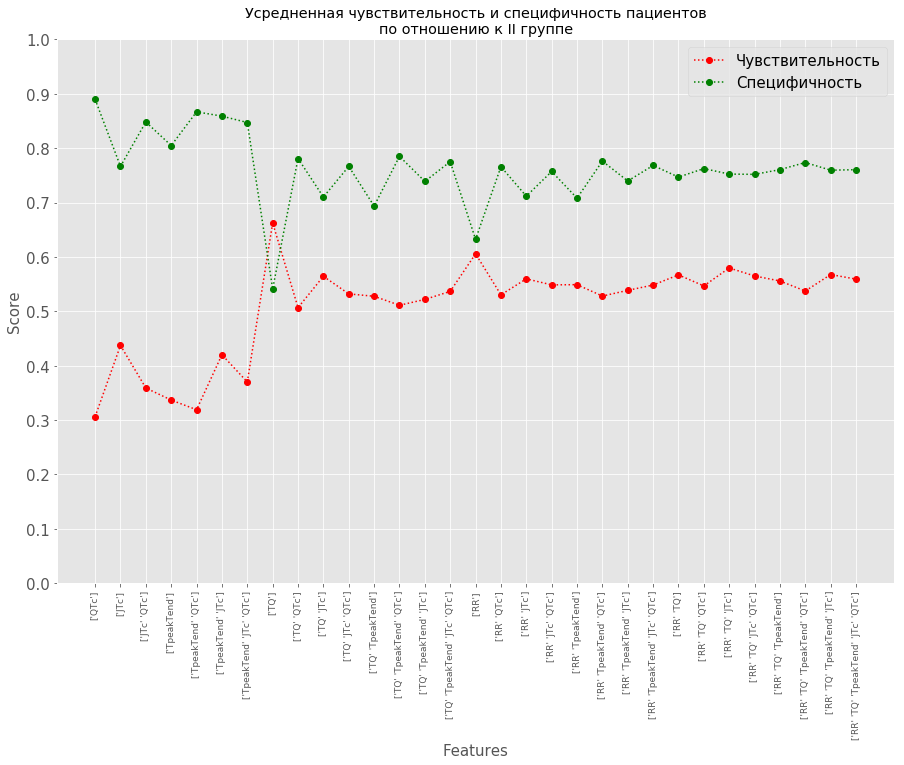

In [26]:
build_plot_for_best_features(plot_labels, indlist,
                             y=[aver_sens_patients, aver_spec_patients],
                             y_arange=np.arange(0., 1.1 ,0.1),
                             marker=[':ro', ':go'],
                             legend_label=['Чувствительность', 
                                           'Специфичность'], 
                             title='Усредненная чувствительность и специфичность пациентов\nпо отношению к II группе', 
                             savefile_name='aver_sens_spec_II_group_patients')